# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION
_An introduction with a statement of the problem you are addressing and a summary of your conclusions.
Is there an introduction with a clear statement of the problem to be addressed? 10%_

_What is our actual purpose?_
- _Identify key features (like aspiration, fuel-type, body-type)._

- _Start with the Kaggle Data_
- _Leverage prior data cleanups via Azure ML Studio_
- _Apply techniques from the autos_

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R. Let's get started ...

#### Class Notes
1. start with graphical exploration (violin plots and such)
1. then hypothesis testing (unless too many features) 
   - IN this case, try principal components distribution/analysis, then a scree plot
1. Try ANOVA
1. Try Box Plot

# Selecting a Dataset (Review in ML Studio)
Use Azure ML Studio's *visualize dataset* and histogram & boxplot views
TODO: Add some screenshots.

- **Cleaned**
  - **Histograms** many lef-skewed histograms; prom_part_5000 looks almost like a normal distro.
  - **Box Plots** 
     - build_year has some garbage 20052009 values
     - almost everything has large outliers
- **Cleaned and SQL-Filtered**
  - **Histograms** much better spread
  - **Box Plots** still some outliers, not as bad
- **Cleaned, SQL-Filtered, Normalized**
  - **Histograms**  Some a a little flat and noisy
  - **Box Plots** All of these are clean
  
My favorite dataset is **Cleaned and SQL-Filtered**

# DATA EXPLORATION
_Discussion of your exploration of the dataset supported by charts and summary statistics. Examine several aspects of the dataset. Explain which aspects are important and why._

_Has the data been properly prepared in terms of cleaning, normalization, etc? Is this preparation consistent with the data exploration?_

_Given the data set and the stated problem, does the data exploration find enlightening relationships in the data? Is the exploration truly in-depth? Are the steps used and inferences drawn clearly explained? A few random histograms and scatter plots are not really good enough, the exploration needs to generate insight._

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics.  

**_Actually, I didn't use the Macro ecomic data_** The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics.  The Macro Economics table includes gdb, commodity prices, USD/Ruble exchange rates, etc.

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

In [1]:
## PROBALBY Skip THE SQL

## Load the data, have a quick look

In [2]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp             full_sq life_sq floor max_floor material build_year
1 4/27/2013 12:00:00 AM 73      36      17    17        1        1979      
2 5/25/2013 12:00:00 AM 53      30      10    16        1        1980      
3 5/27/2013 12:00:00 AM 41      37      13    17        1        1979      
4 5/27/2013 12:00:00 AM 77      41       2    17        6        2014      
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
  num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
1 2        11       3     ⋯  8.44           0                     0         
2 2         8       3     ⋯ 17.64          10                179554         
3 1         1       1     ⋯  1.45           0                     0         
4 3        12       1     ⋯  1.64           0                     0         
5 2         6       3     ⋯  0.74           0                     0         
6 1         8       3     ⋯ 21.51           4                 31280         
  prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
1  8.28           0                     0           6.22         
2 16.69          14                529054          18.47         
3  2.01           0                     0           4.45         
4  1.98           0                     0           4.75         
5  1.99           1                 15000           8.05         
6 18.78          15                136990          11.12         
  office_count_5000 office_sqm_5000 price_doc
1  2                 138650         10100000 
2 25                 766701          9000000 
3  0                      0          4457400 
4  0                      0          7011550 
5  3                  81947          7100000 
6 83                3903973          6450000

'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

In [3]:
real_estate = na.omit(real_estate)
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 9233   64

timestamp             full_sq life_sq floor max_floor material build_year
5  5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6  5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7  5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
8  5/30/2013 12:00:00 AM 74      46      12    24        1        2004      
9  6/1/2013 12:00:00 AM  51      30       7    17        1        2003      
10 6/3/2013 12:00:00 AM  77      50       3     5        2        1957      
   num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
5  2        6        3     ⋯  0.74           0                      0        
6  1        8        3     ⋯ 21.51           4                  31280        
7  2        1        1     ⋯ 26.61           0                      0        
8  3        9        3     ⋯ 18.95           6                 108184        
9  2        9        3     ⋯ 24.09           1                 104000        
10 3        8        2     ⋯ 17.48          68                1849285        
   prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
5   1.99            1                 15000          8.05         
6  18.78           15                136990         11.12         
7  13.06            0                     0          6.54         
8  10.98            8                115507         12.31         
9  18.74            3                183000         13.57         
10 14.22          145               3353936         14.54         
   office_count_5000 office_sqm_5000 price_doc
5    3                 81947          7100000 
6   83               3903973          6450000 
7    1                 26950          5903808 
8   30                651686         12100000 
9   11                385012          7700000 
10 426               6956461         11700000

'data.frame':	9233 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## _Date Time Practice_

In [1]:
dtimes = c("2002-06-09 12:45:40 AM","2003-01-29 09:30:40 AM",
            "2002-09-04 16:45:40 AM","2002-11-13 20:00:40 AM",
            "2002-07-07 17:30:40 AM")
dtimes

[1] "2002-06-09 12:45:40 AM" "2003-01-29 09:30:40 AM" "2002-09-04 16:45:40 AM"
[4] "2002-11-13 20:00:40 AM" "2002-07-07 17:30:40 AM"

In [2]:
dtimes = as.data.frame(c("6/9/2002 12:45:40 AM","1/29/2003 09:30:40 AM",
           "9/4/2002 16:45:40 AM","11/13/2002 20:00:40 AM",
           "7/7/2002 17:30:40 AM"))
colnames(dtimes) = c("timestamp")
dtimes

timestamp             
1 6/9/2002 12:45:40 AM  
2 1/29/2003 09:30:40 AM 
3 9/4/2002 16:45:40 AM  
4 11/13/2002 20:00:40 AM
5 7/7/2002 17:30:40 AM

In [8]:
require(chron)
thetimes = chron(dates=dtimes[,1],times=dtimes[,2],
                  format=c('y-m-d','h:m:s'))
thetimes

ERROR: Error in convert.dates(dates., format = format[[1]], origin. = origin.): object dates. must be numeric or character


In [3]:
dtimes[,1]

[1] 6/9/2002 12:45:40 AM   1/29/2003 09:30:40 AM  9/4/2002 16:45:40 AM  
[4] 11/13/2002 20:00:40 AM 7/7/2002 17:30:40 AM  
5 Levels: 11/13/2002 20:00:40 AM ... 9/4/2002 16:45:40 AM

In [5]:
dtimes$date = as.Date(dtimes[,1],format='%m/%d/%Y')
dtimes$time = as.Time(dtimes[,1],format='%hh:%mm/%ss')
dtimes
str(dtimes)

ERROR: Error in eval(expr, envir, enclos): could not find function "as.Time"


## Add Date to supplement timestamp

In [8]:
dtimes$date = as.Date(dtimes[,1],format='%m/%d/%Y')
dtimes

timestamp              date      
1 6/9/2002 12:45:40 AM   2002-06-09
2 1/29/2003 09:30:40 AM  2003-01-29
3 9/4/2002 16:45:40 AM   2002-09-04
4 11/13/2002 20:00:40 AM 2002-11-13
5 7/7/2002 17:30:40 AM   2002-07-07

## Add Price Per Square Meter & Parse the date

In [9]:
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
head(real_estate,3)
str(real_estate)

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_sqm_2000 prom_part_3000 office_count_3000
5 2        6        3     ⋯     0            1.99           1               
6 1        8        3     ⋯ 31280           18.78          15               
7 2        1        1     ⋯     0           13.06           0               
  office_sqm_3000 prom_part_5000 office_count_5000 office_sqm_5000 price_doc
5  15000           8.05           3                  81947         7100000  
6 136990          11.12          83                3903973         6450000  
7      0           6.54           1                  26950         5903808  
  price_sqm date      
5 157777.78 2013-05-27
6 169736.84 2013-05-28
7  93711.24 2013-05-28

'data.frame':	9233 obs. of  66 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density Plots

### Density Plot of Price

In [10]:
require(ggplot2)
plot.density = function(df, field, title, xlabel){
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(df, aes(field)) + 
      geom_density() + 
      xlab(xlabel) + 
      ggtitle(title) + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))   
}

Loading required package: ggplot2


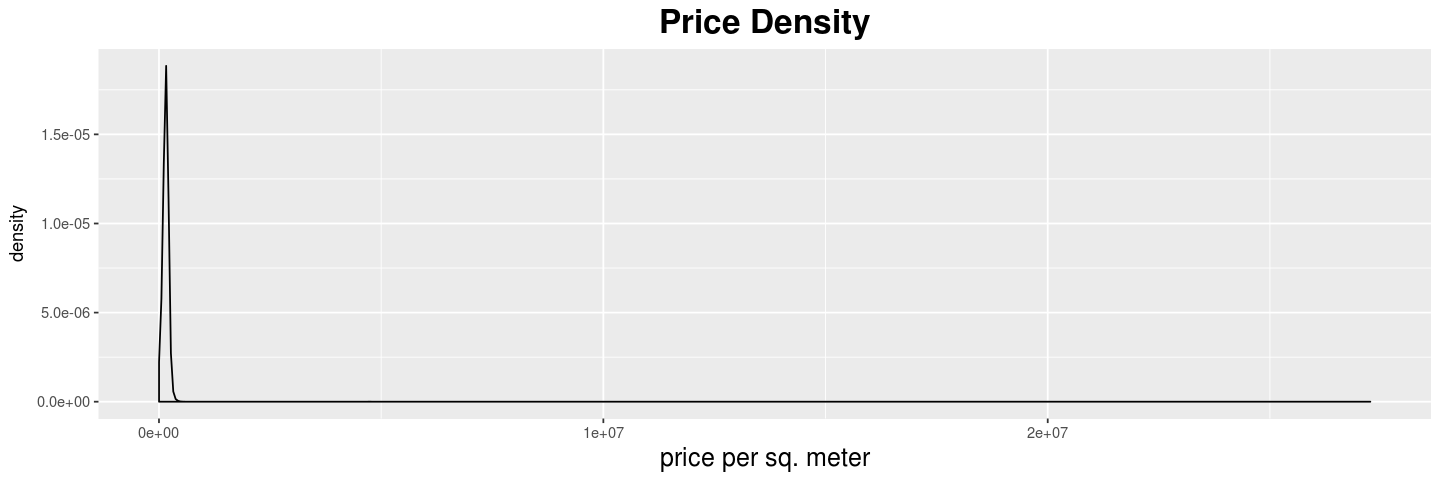

In [11]:
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(real_estate, aes(price_sqm)) + 
      geom_density() + 
      xlab("price per sq. meter") + 
      ggtitle("Price Density") + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))

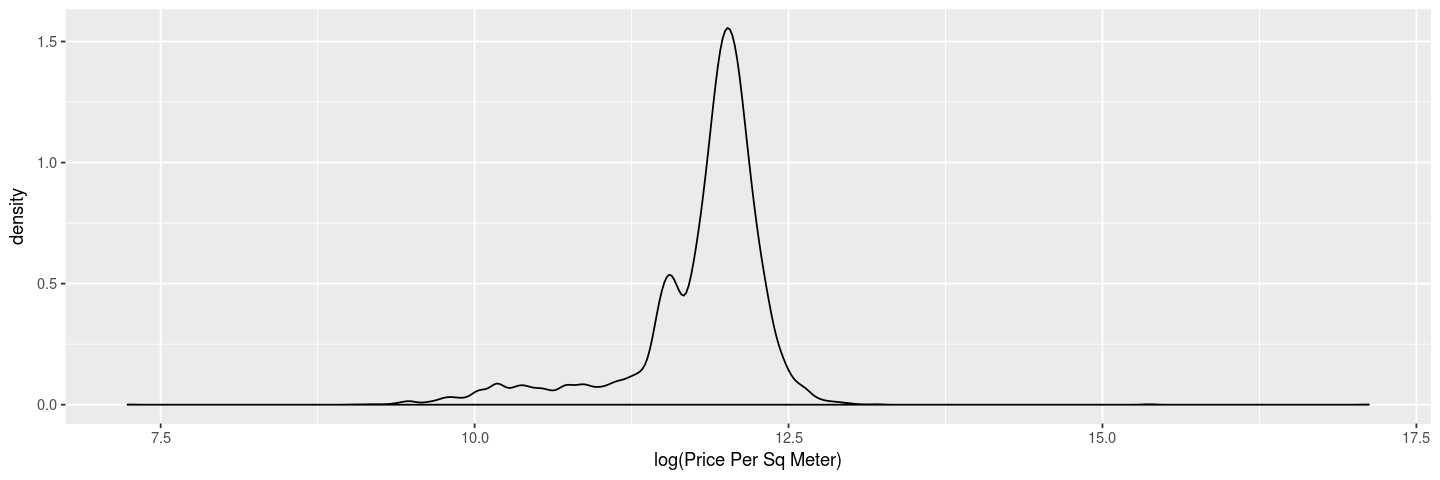

In [12]:
options(repr.plot.width=12, repr.plot.height=4)
real_estate$log.price_sqm = log(real_estate$price_sqm)
# head(real_estate)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

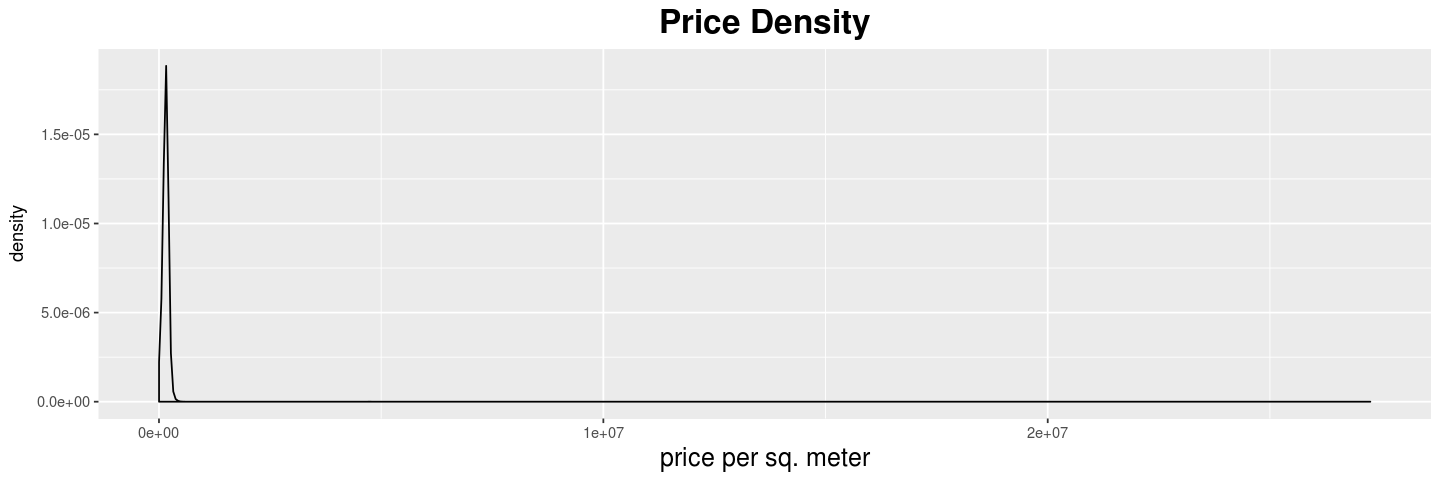

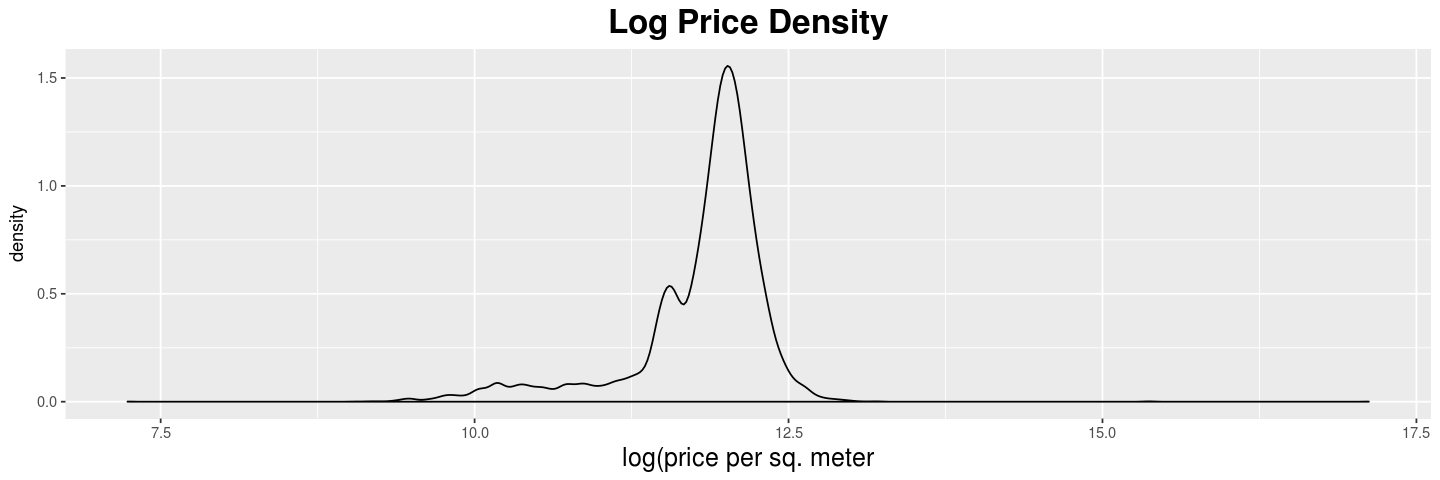

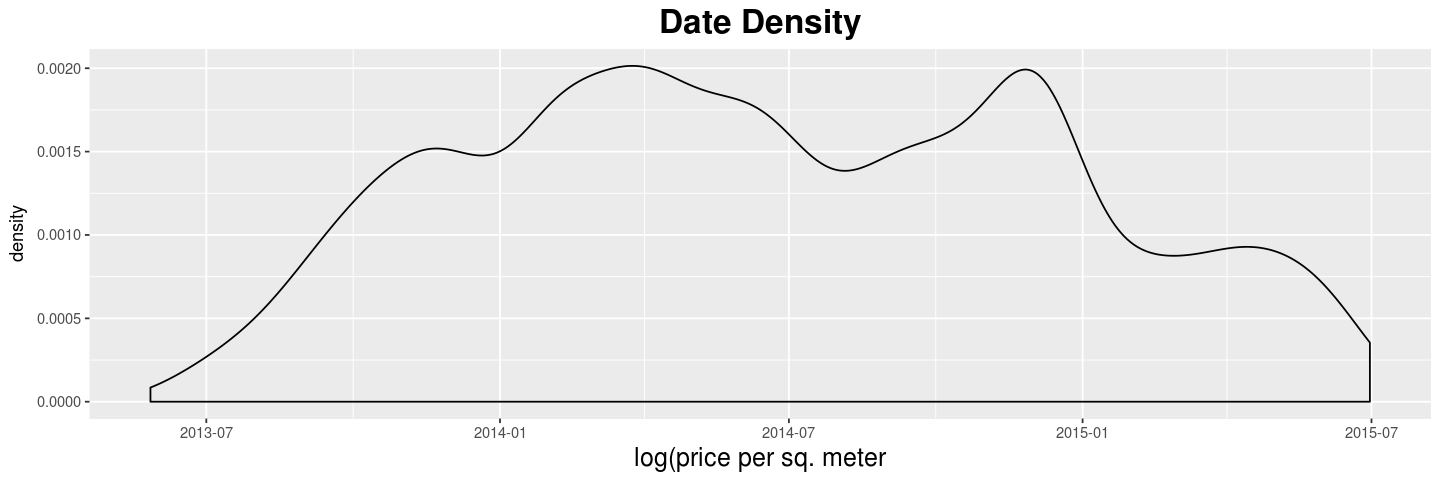

In [13]:
plot.density(df = real_estate, field = real_estate$price_sqm, title = "Price Density", 
             xlab= "price per sq. meter")
plot.density(df = real_estate, field = real_estate$log.price_sqm, title = "Log Price Density", 
             xlab= "log(price per sq. meter")
plot.density(df = real_estate, field = real_estate$date, title = "Date Density", 
             xlab= "log(price per sq. meter")

Warning message:
“Removed 11 rows containing non-finite values (stat_density).”

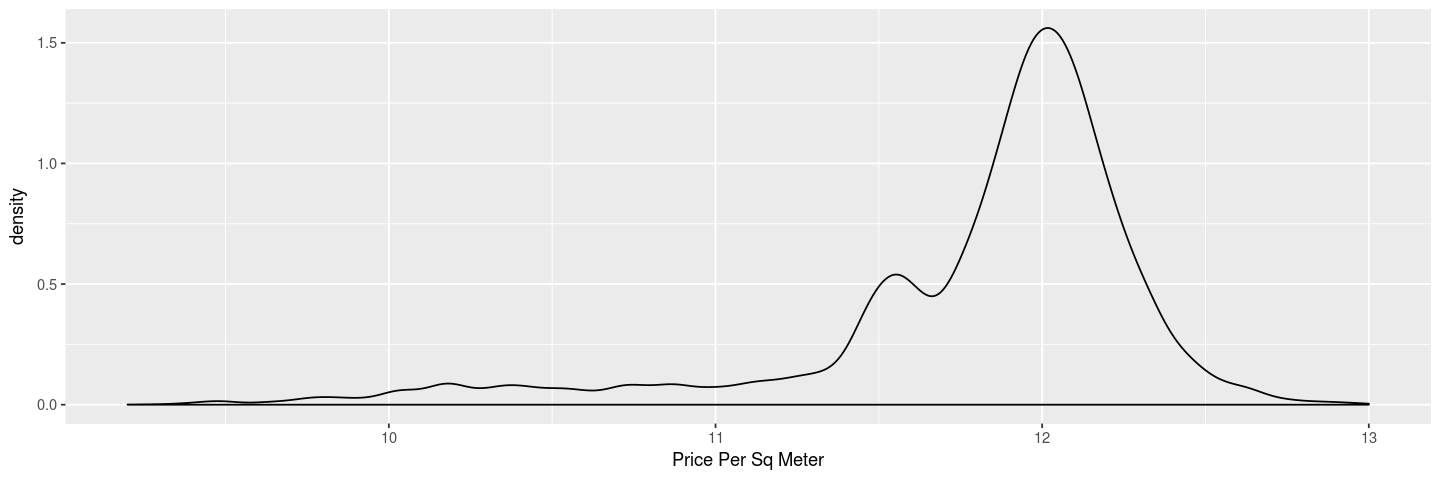

In [14]:
# For cleaned, sql'ed, normalized
x_min = 9.2
x_max = 13

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

In [15]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
real_estate = real_estate.trimmed
dim(real_estate)

[1] 9222   67

In [16]:
dim(real_estate)
str(real_estate)

[1] 9222   67

'data.frame':	9222 obs. of  67 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

# A Scatterng of Scatterplots: The search for meaning

Loading required package: car


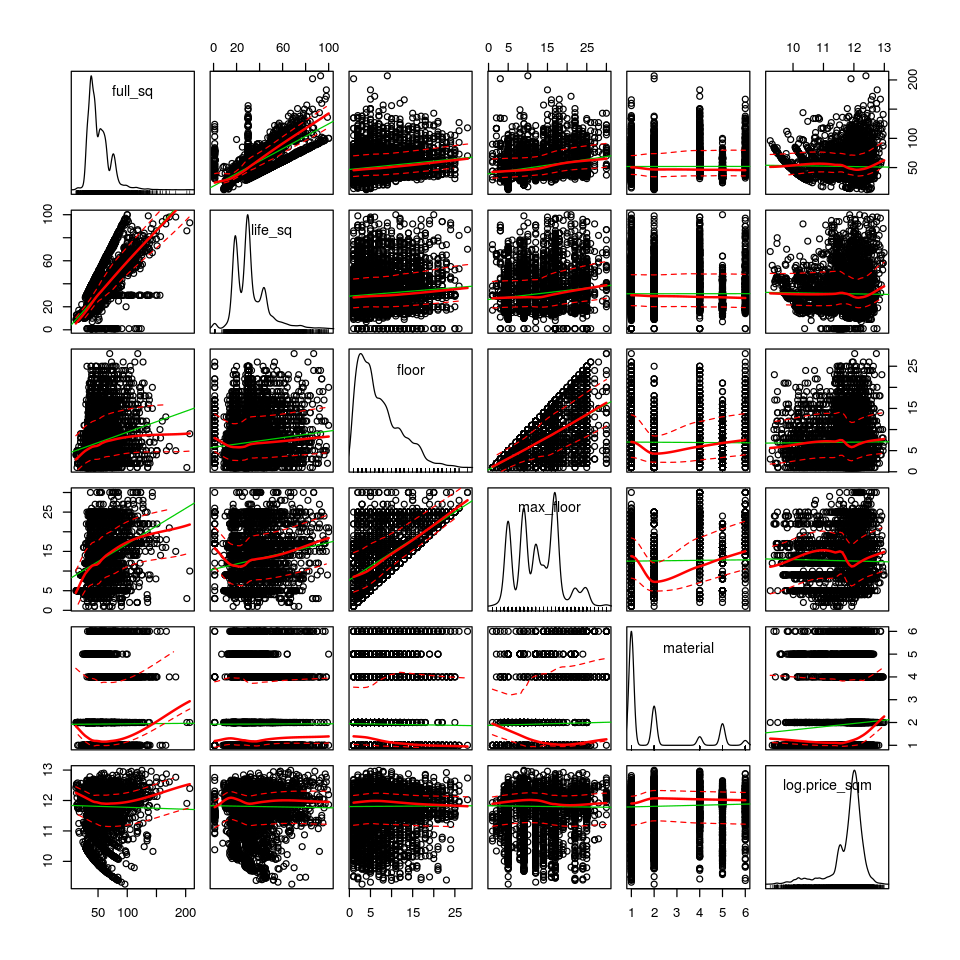

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  full_sq +
                  life_sq +
                  floor +
                  max_floor +
                  material +
                  log.price_sqm,
                  data = real_estate)

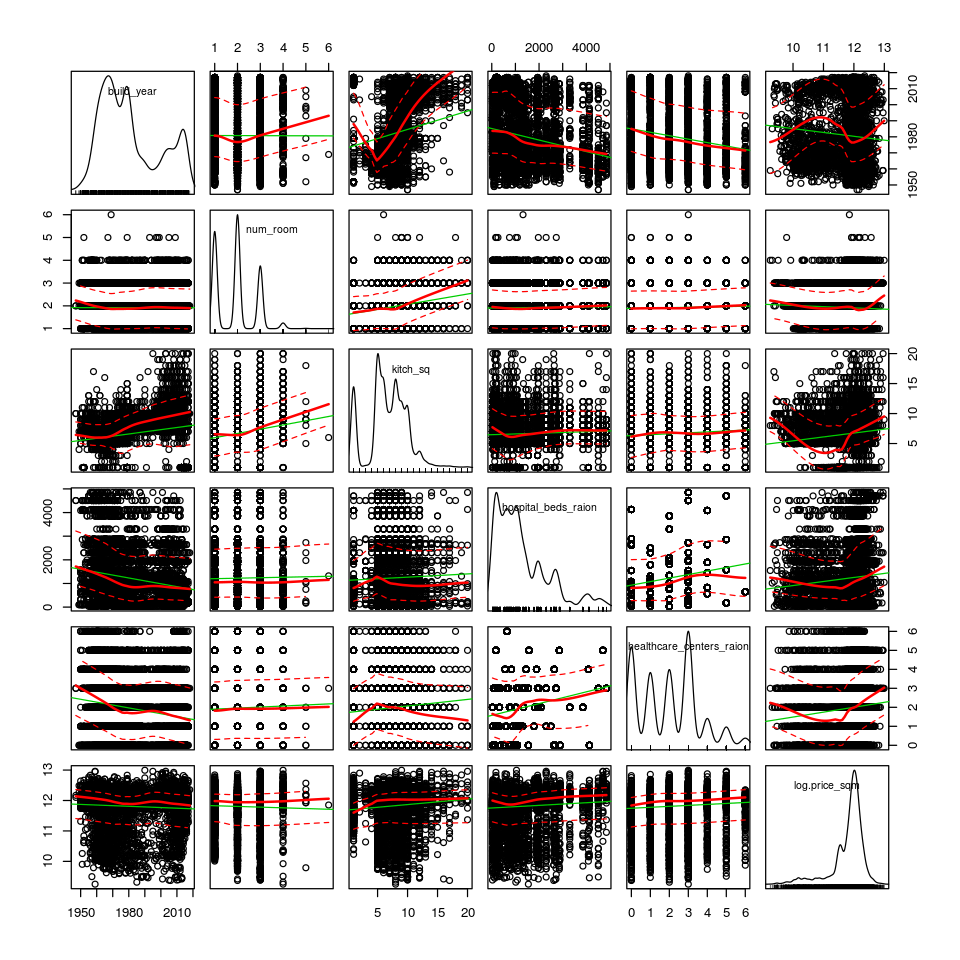

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  build_year +
                  num_room +
                  kitch_sq +
                  hospital_beds_raion +
                  healthcare_centers_raion +
                  log.price_sqm,
                  data = real_estate)

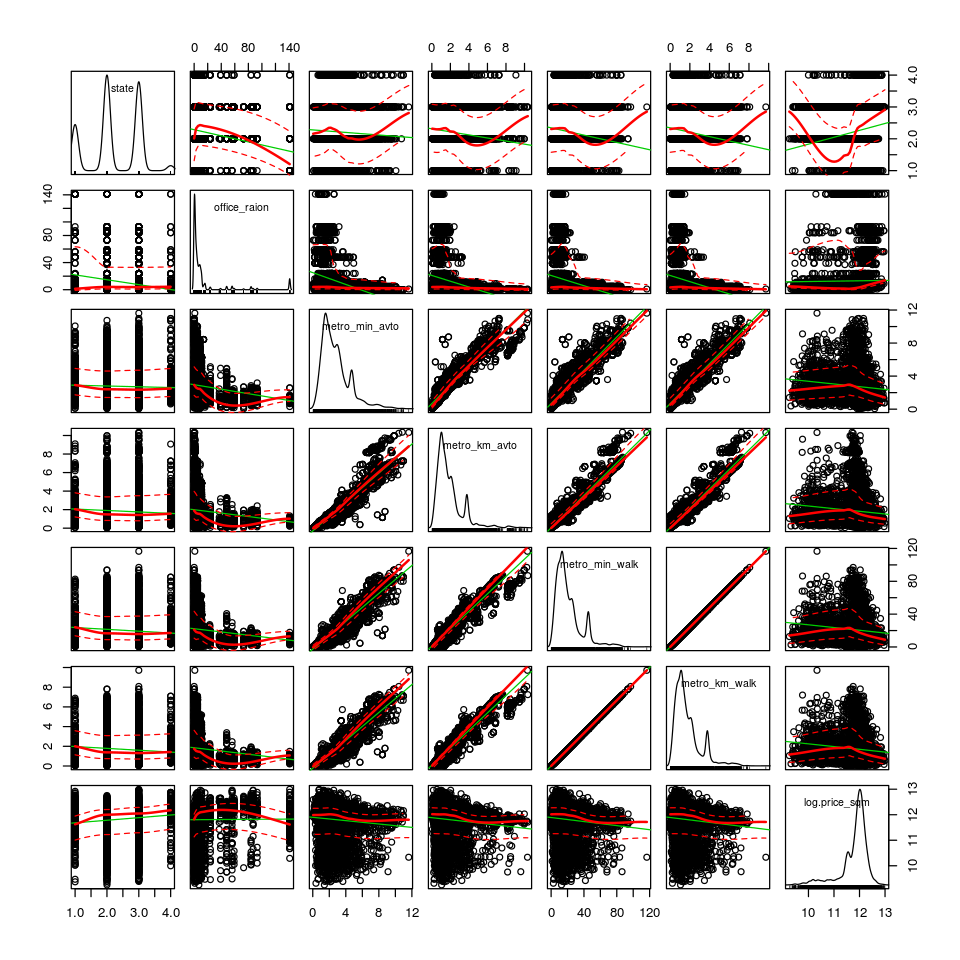

In [19]:
scatterplotMatrix(~ 
                 state +
                  office_raion   +
                  metro_min_avto +
                  metro_km_avto  +
                  metro_min_walk +
                  metro_km_walk +
                  log.price_sqm,
                  data = real_estate)

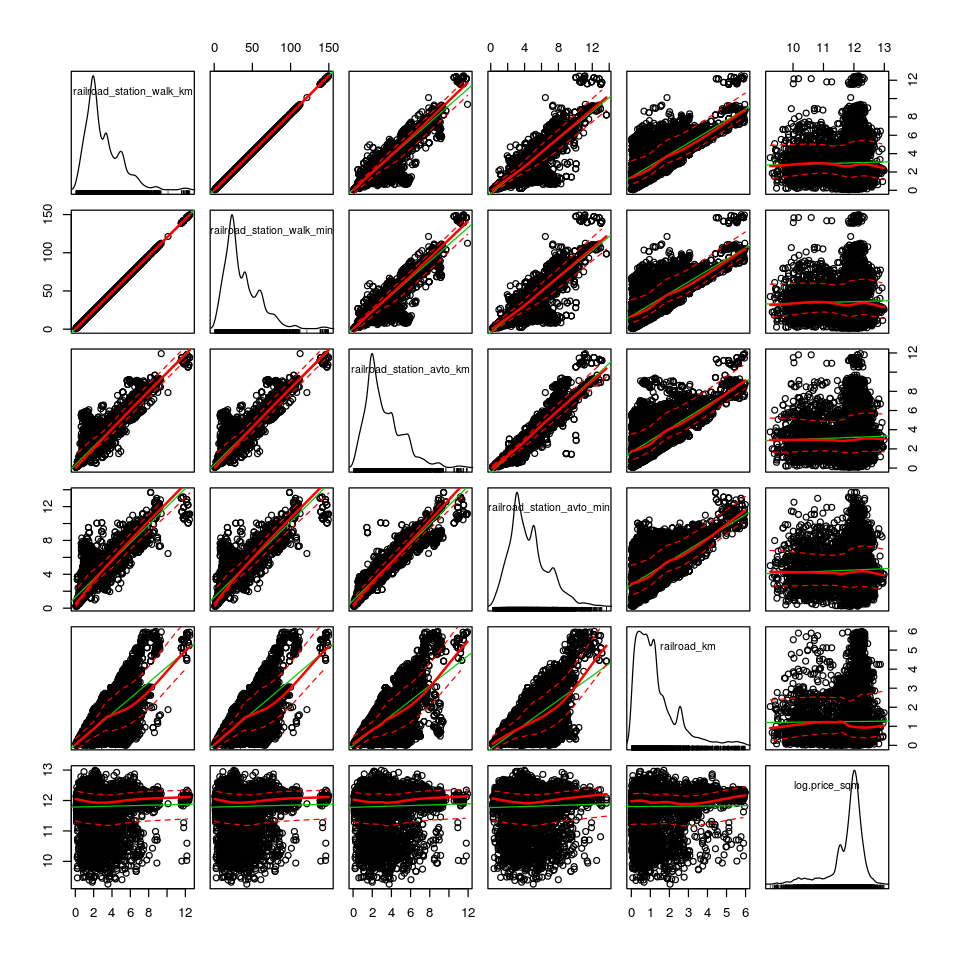

In [20]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                    railroad_station_walk_km          +
                    railroad_station_walk_min         +
                    railroad_station_avto_km          +
                    railroad_station_avto_min         +
                   railroad_km                      +
                  log.price_sqm,
                  data = real_estate)

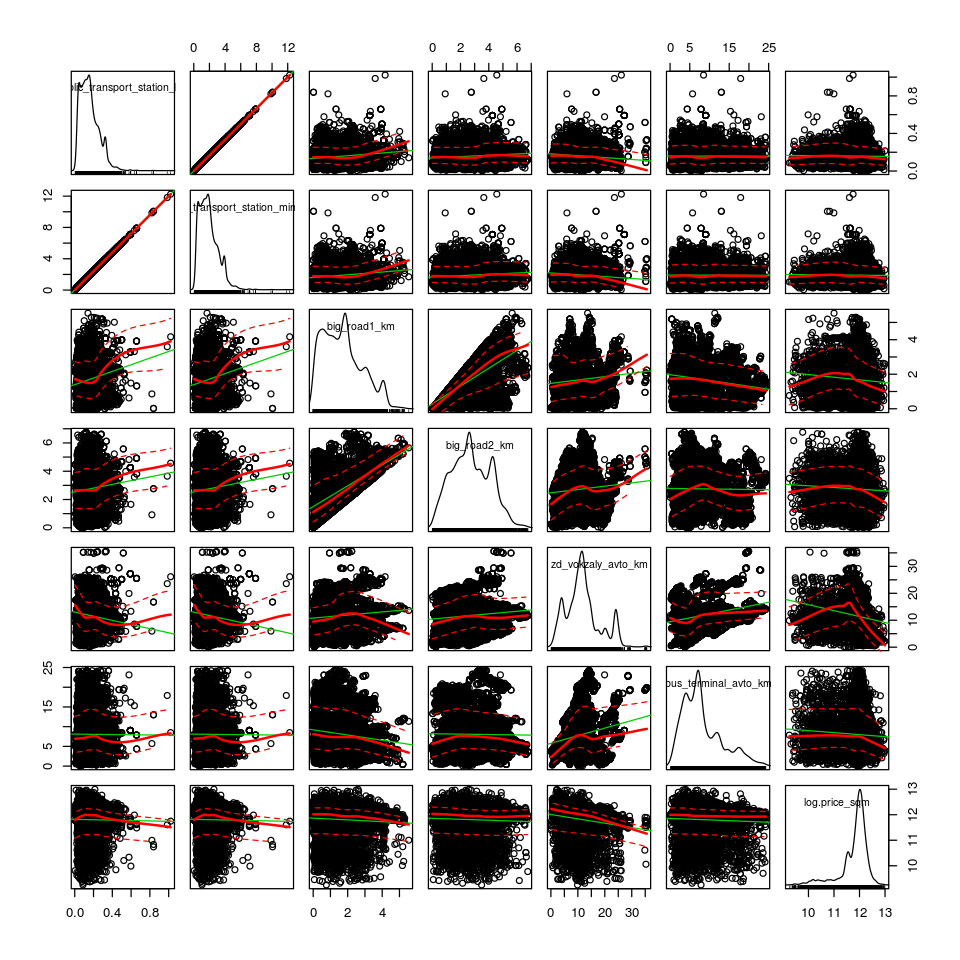

In [21]:
scatterplotMatrix(~ 
                public_transport_station_km       +
                public_transport_station_min_walk +
                big_road1_km                     +
                big_road2_km                     +
                zd_vokzaly_avto_km               +
                bus_terminal_avto_km             +
                  log.price_sqm,
                  data = real_estate)

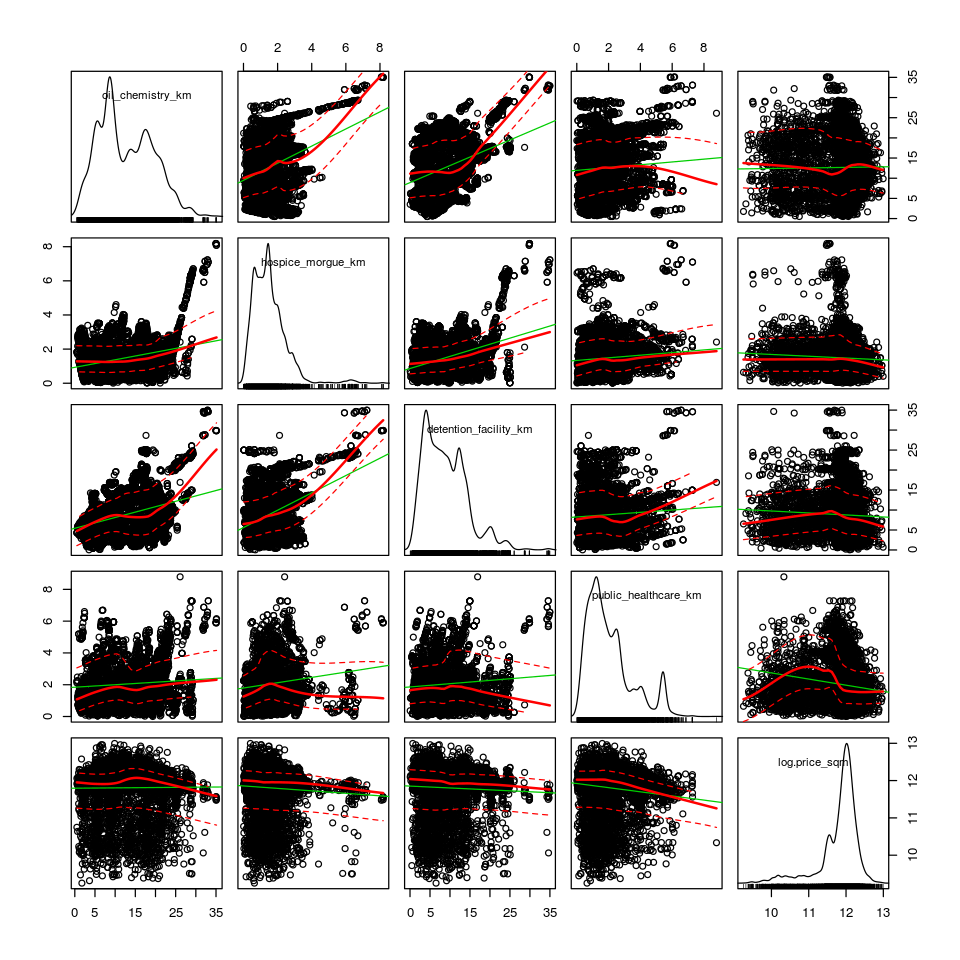

In [22]:
scatterplotMatrix(~ 
                oil_chemistry_km                 +
                hospice_morgue_km                +
                detention_facility_km            +
                public_healthcare_km             +
                  log.price_sqm,
                  data = real_estate)

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”

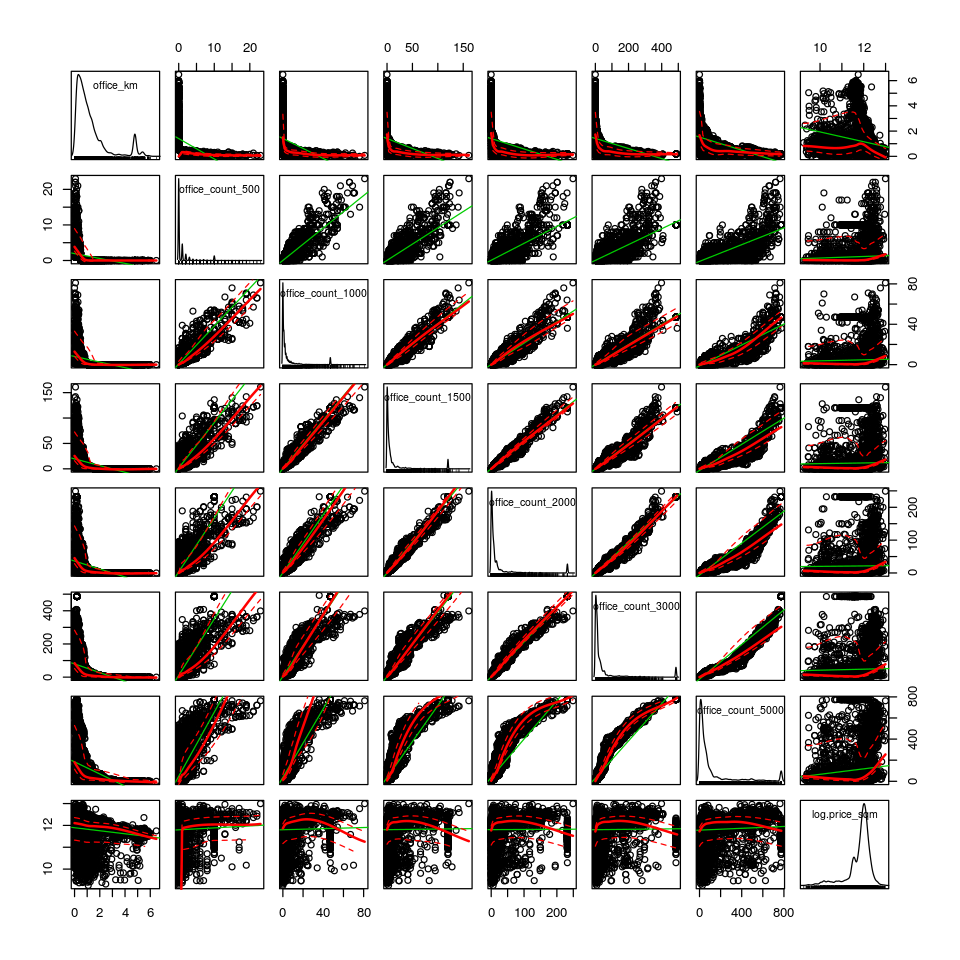

In [23]:
scatterplotMatrix(~ 
                office_km                        +
                office_count_500                 +
                office_count_1000                +
                office_count_1500                +
                office_count_2000                +
                office_count_3000                +
                office_count_5000                +
                  log.price_sqm,
                  data = real_estate)

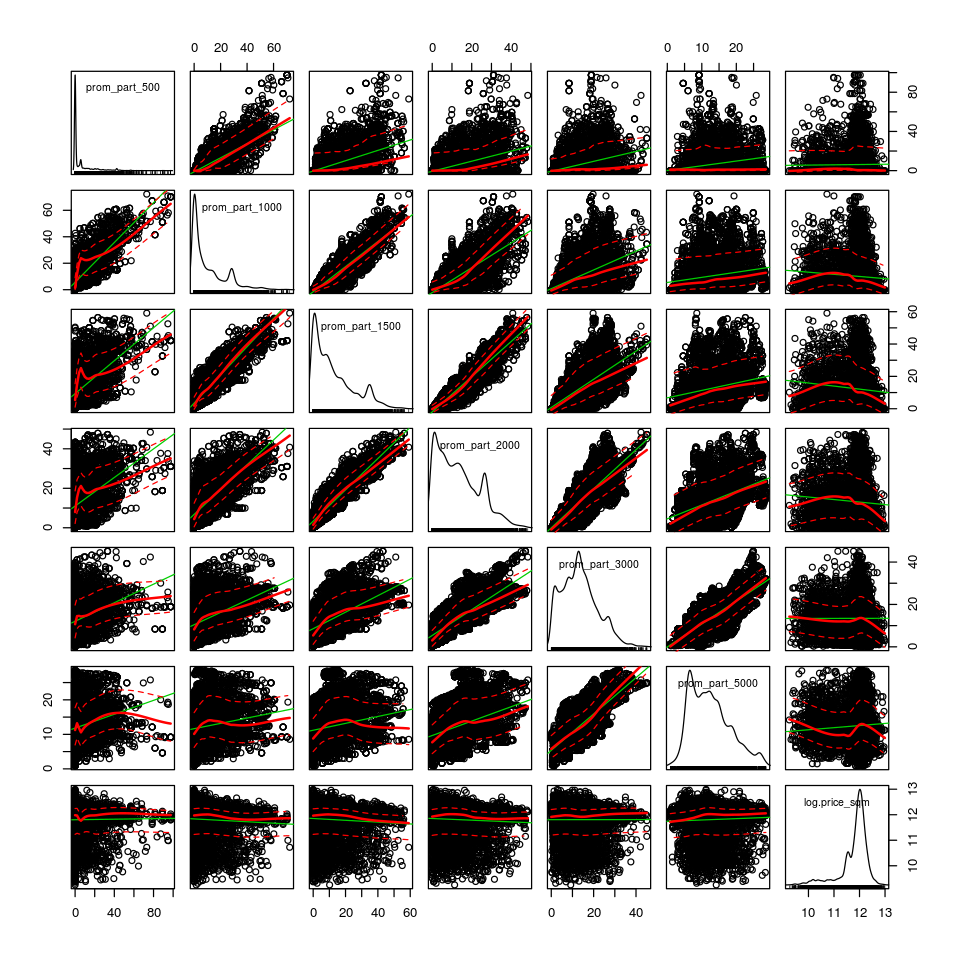

In [24]:
scatterplotMatrix(~ 
                  prom_part_500                    +
                  prom_part_1000                   +
                  prom_part_1500                   +
                  prom_part_2000                   +
                  prom_part_3000                   +
                  prom_part_5000                   +

                  log.price_sqm,
                  data = real_estate)

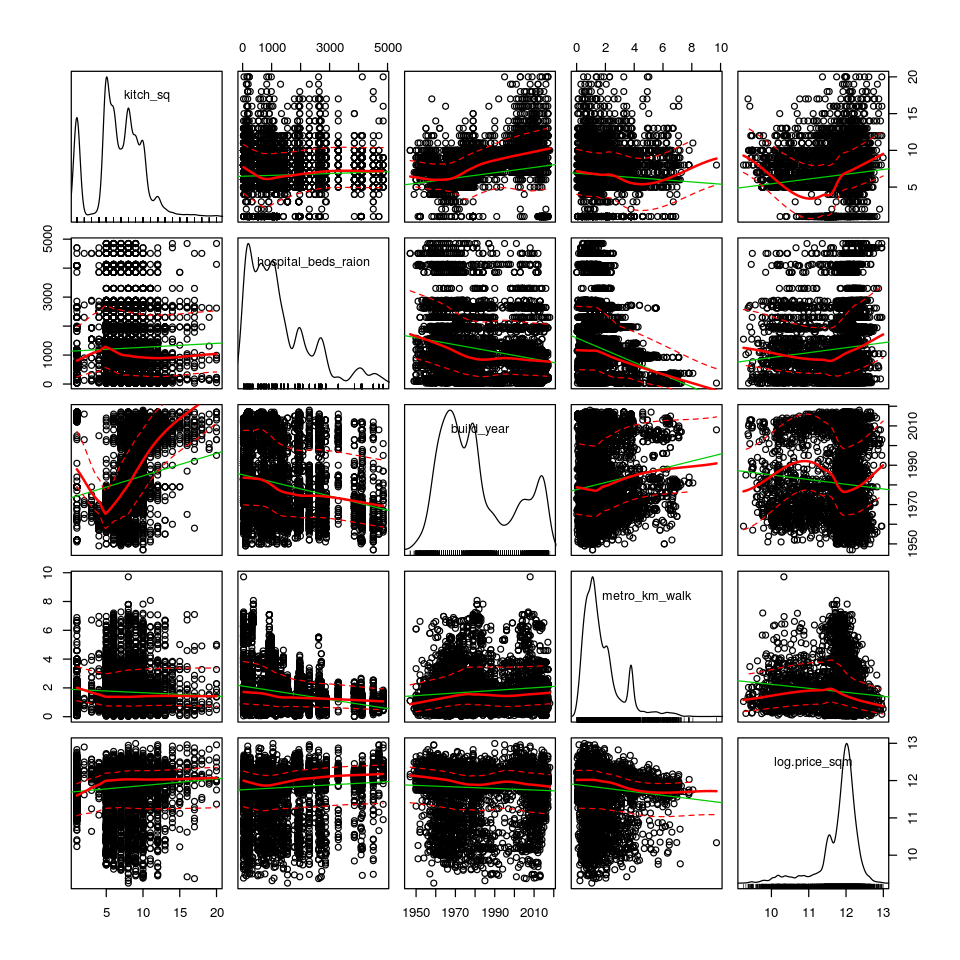

In [25]:
scatterplotMatrix(~ 
                  kitch_sq +
                  hospital_beds_raion +
                  build_year +
                  metro_km_walk +           
                  log.price_sqm,
                  data = real_estate)

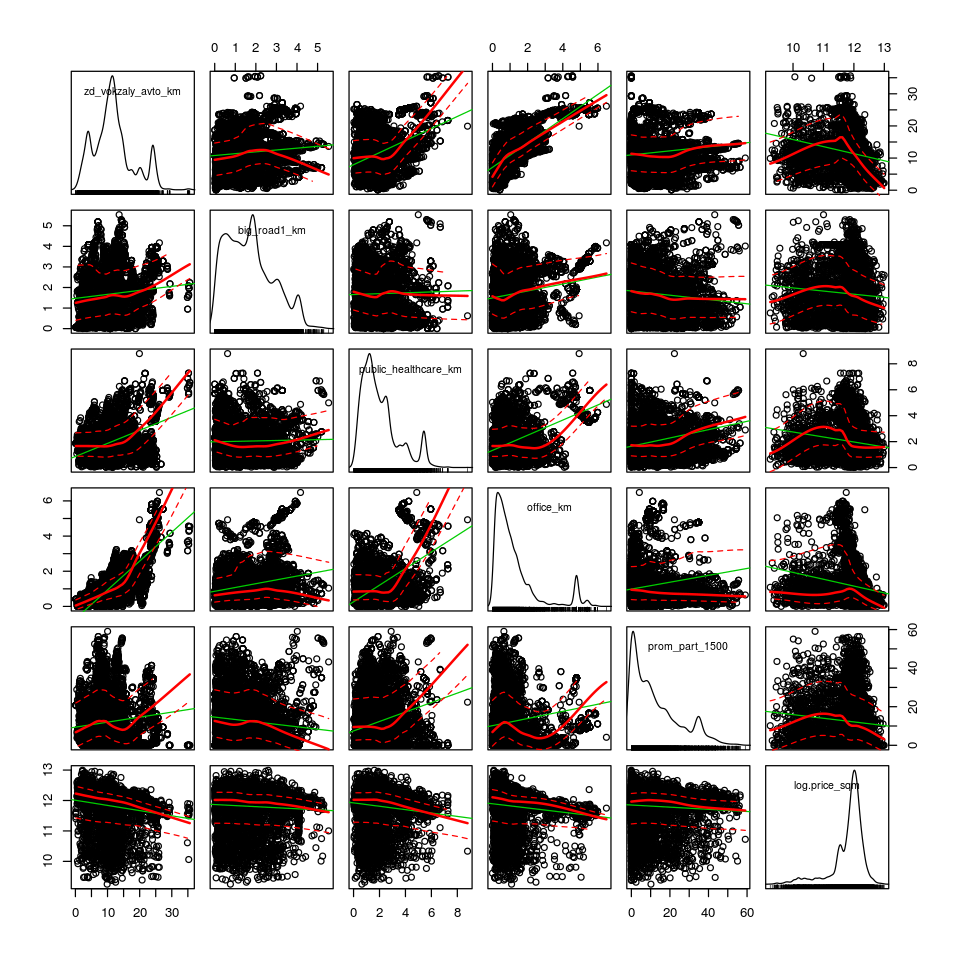

In [26]:
scatterplotMatrix(~ 
                  zd_vokzaly_avto_km +
                  big_road1_km +
                  public_healthcare_km +
                  office_km +
                  prom_part_1500 +
                  log.price_sqm,
                  data = real_estate)

Potential Categories
- Material
- healthcare_centers_raion
- state
Potential Parameters (ordered by influence)
- zd_vokzaly_avto_km
- office_km
- public_healthcare_km
- prom_part_1500

- kitch_sq
- hospital_beds_raion
- build_year
- metro_km_walk
- big_road1_km

In [27]:
## Color plots

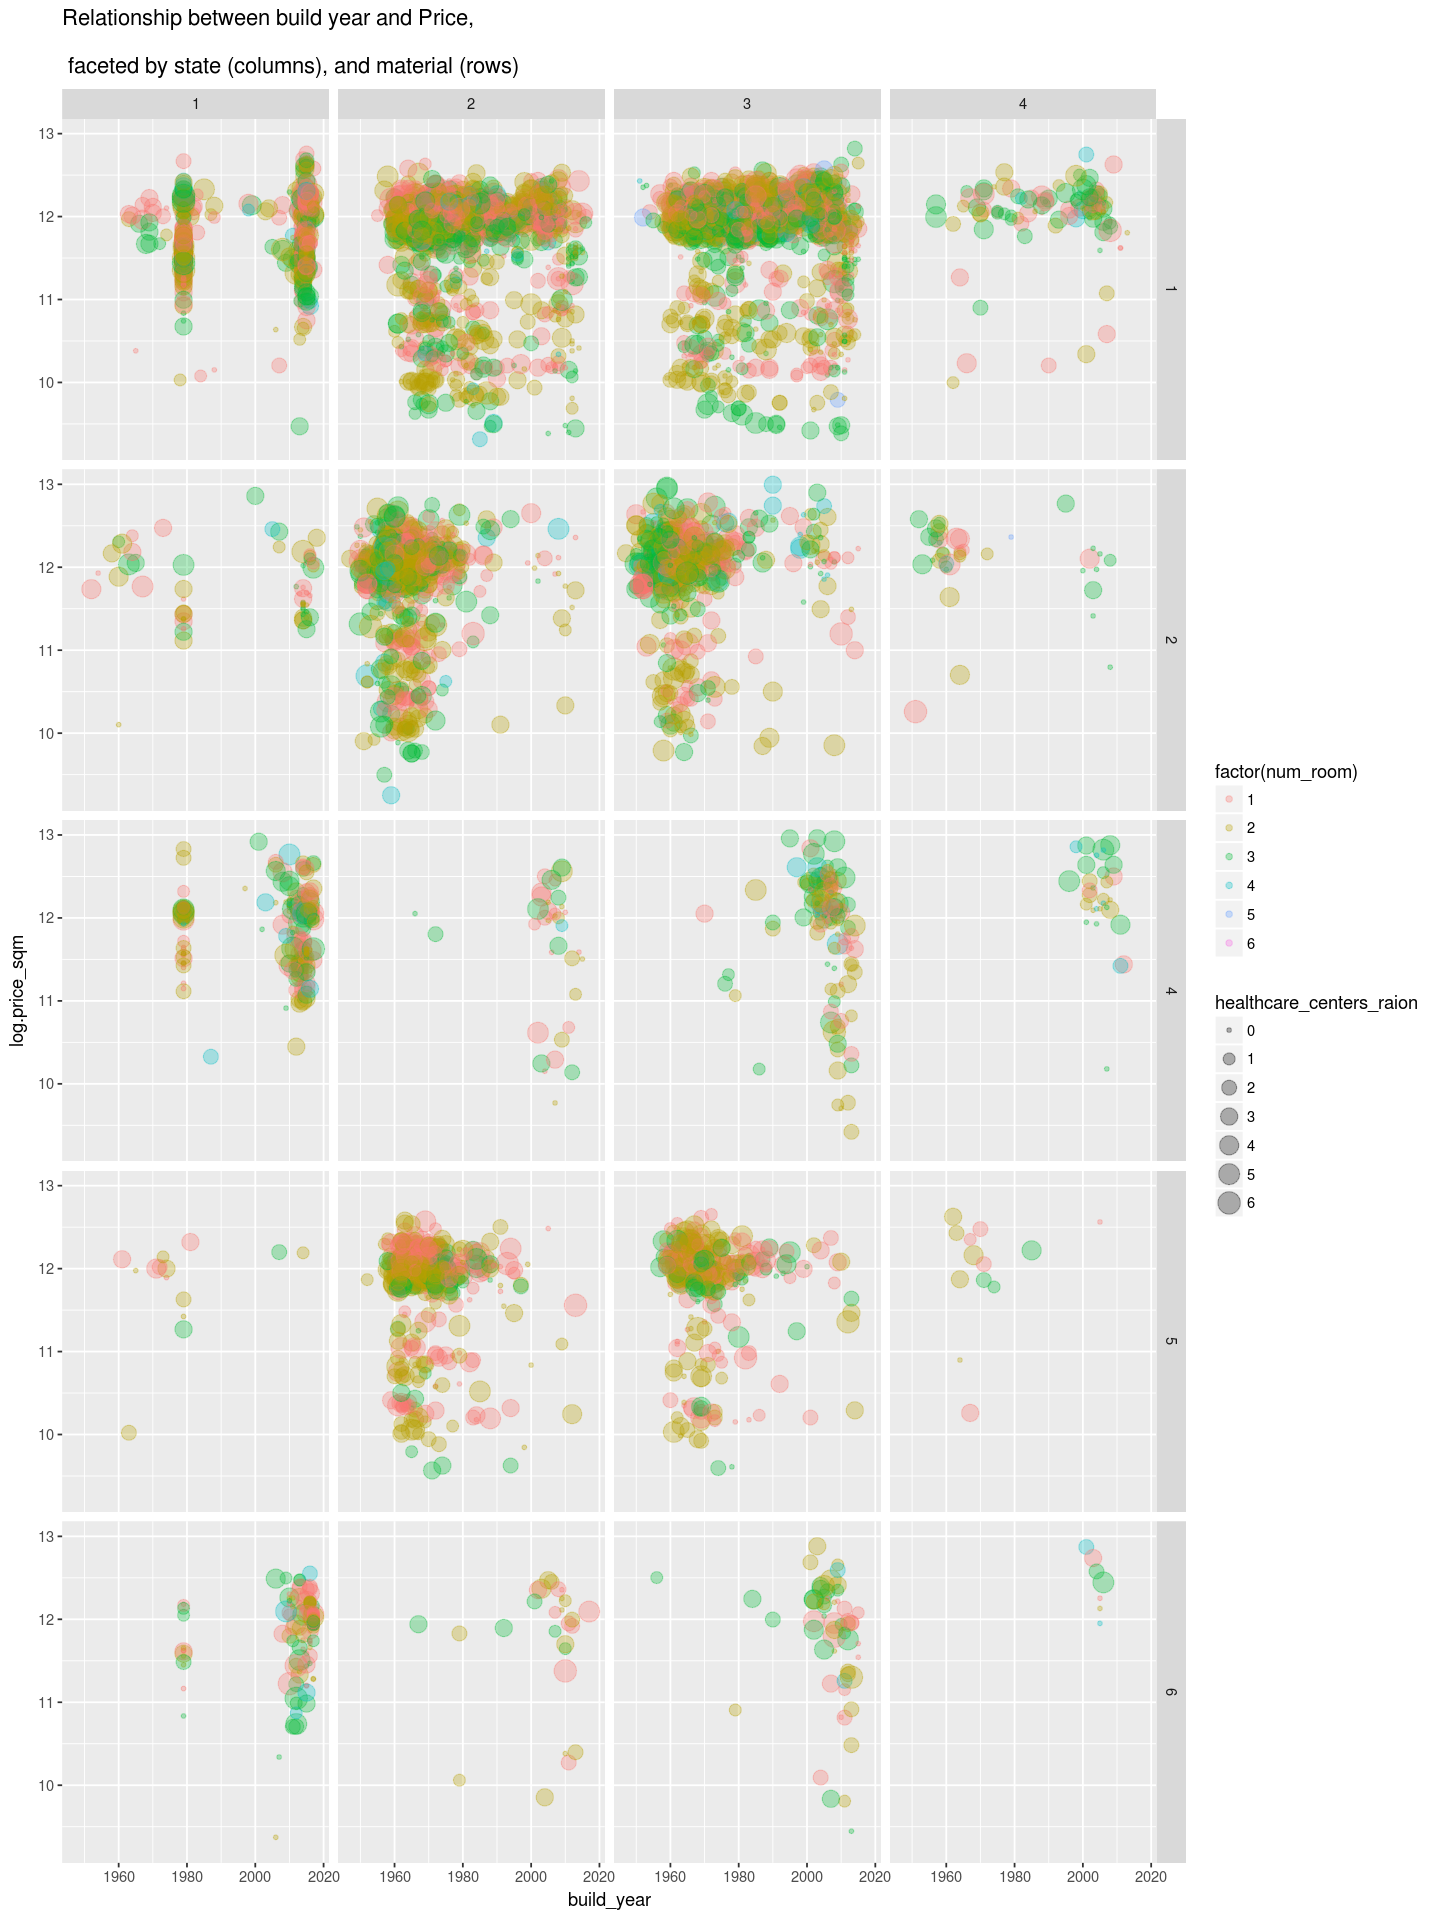

In [28]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(num_room), 
           size = healthcare_centers_raion), alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows)')

Potential Categories
- Material
- healthcare_centers_raion
- state

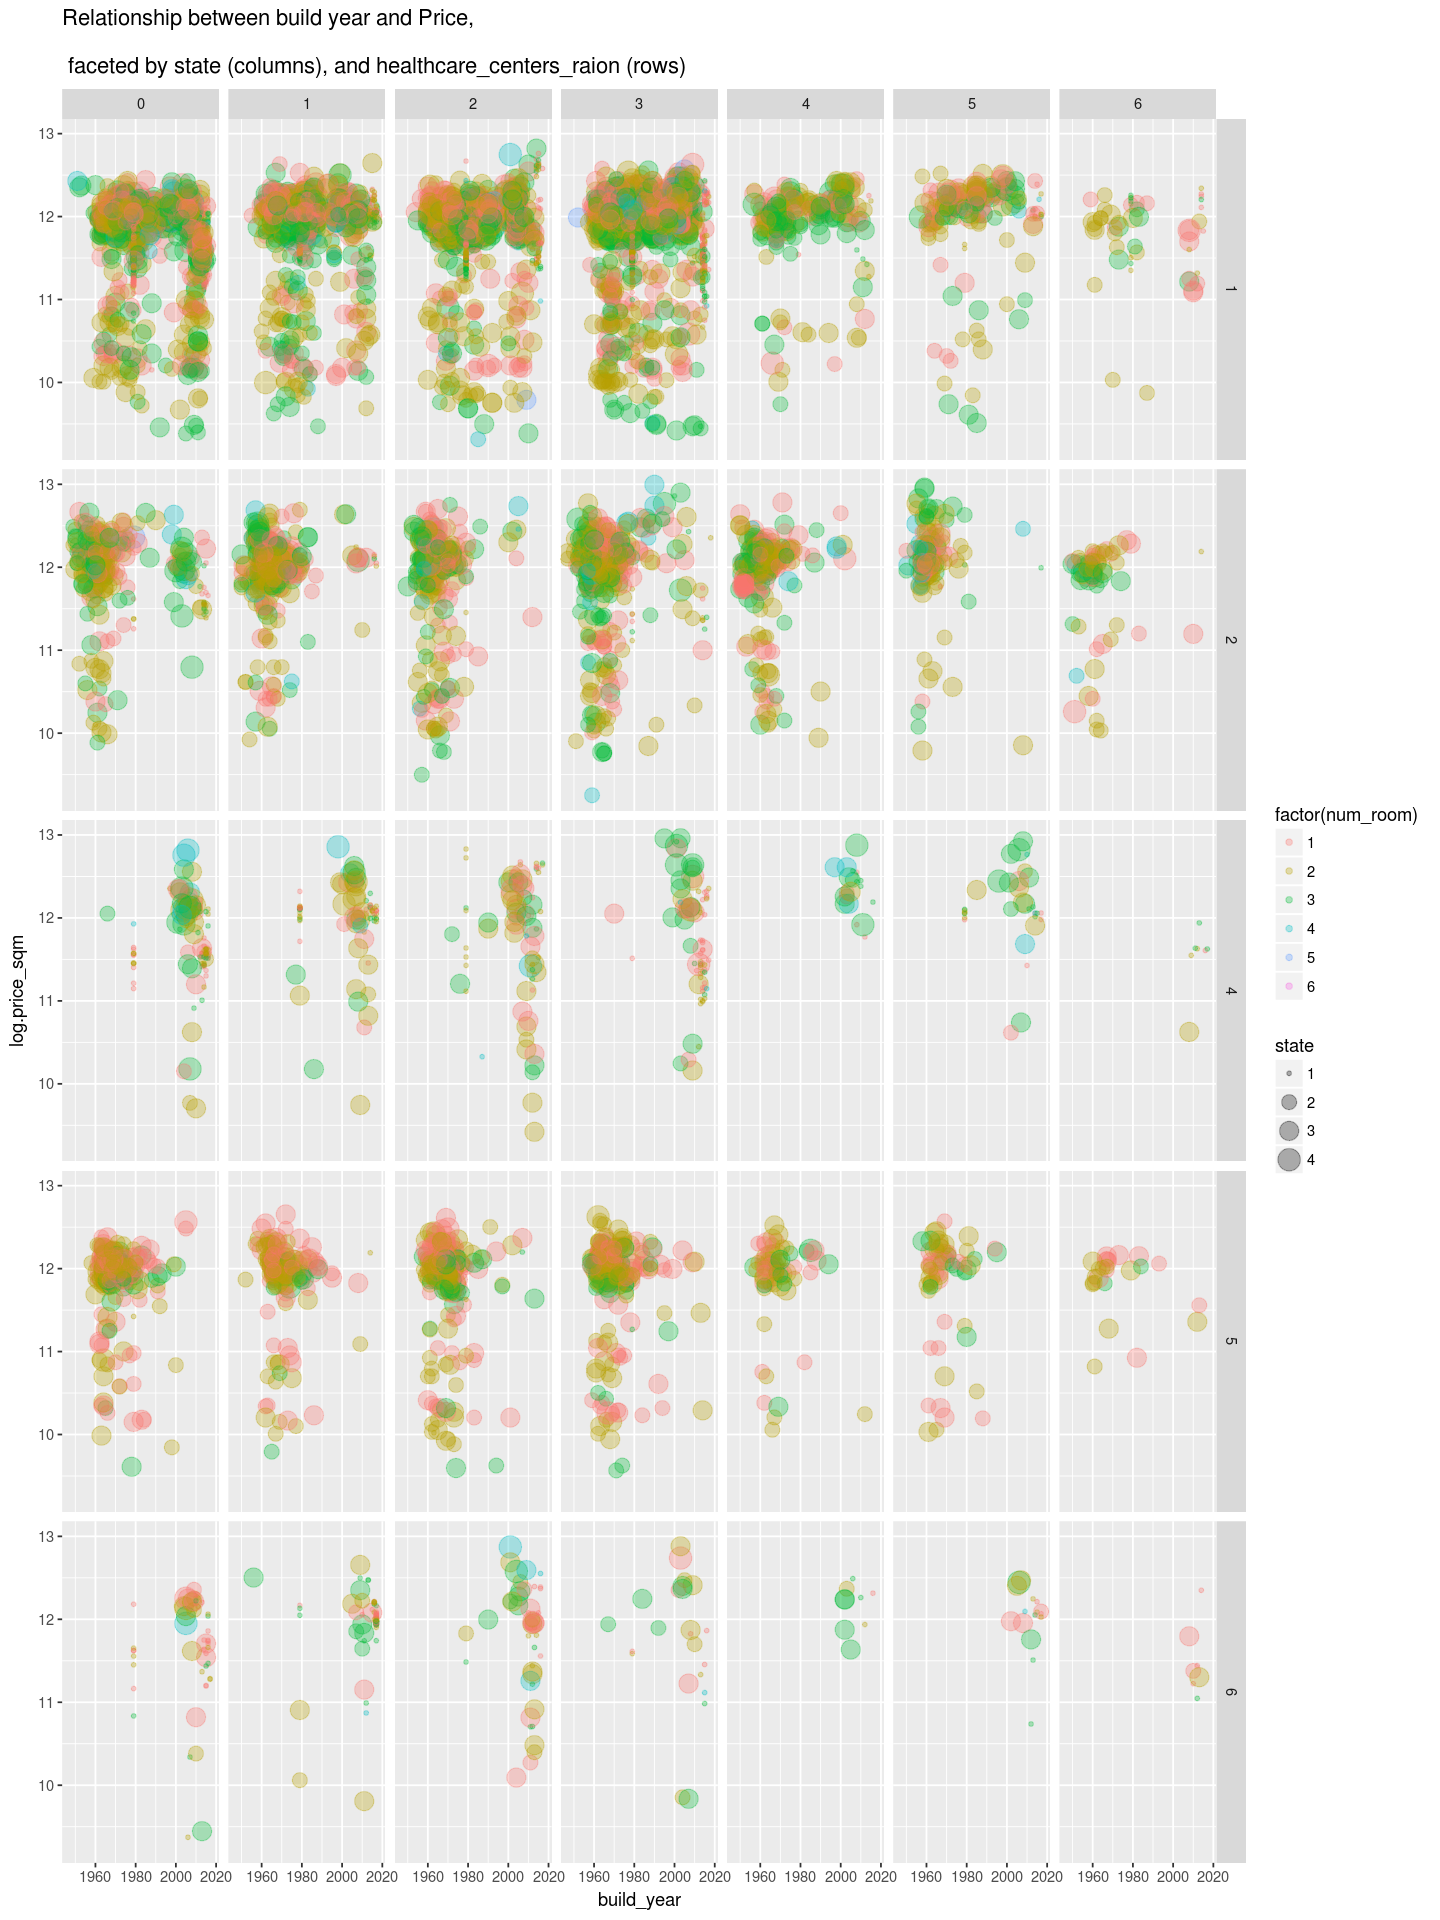

In [29]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(material ~ healthcare_centers_raion) +
geom_point(aes(color = factor(num_room), 
           size = state), alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and healthcare_centers_raion (rows)')

In [30]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(healthcare_centers_raion ~ num_room) +
geom_point(aes(color = factor(state), 
           size = material), alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by number of rooms (columns), and Healthcare centers (rows)')

## Possible ways to split things (like autos/fuel/body...)
- Build year before/after 2000
- material
- state
- rooms
** Try out bootstrapped difference of means**

In [31]:
# Create a Century field.
real_estate$century = ifelse(real_estate$build_year < 2000, 20, 21)
head(real_estate)

timestamp             full_sq life_sq floor max_floor material build_year
5  5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6  5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7  5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
8  5/30/2013 12:00:00 AM 74      46      12    24        1        2004      
9  6/1/2013 12:00:00 AM  51      30       7    17        1        2003      
10 6/3/2013 12:00:00 AM  77      50       3     5        2        1957      
   num_room kitch_sq state ⋯ office_count_3000 office_sqm_3000 prom_part_5000
5  2        6        3     ⋯   1                 15000          8.05         
6  1        8        3     ⋯  15                136990         11.12         
7  2        1        1     ⋯   0                     0          6.54         
8  3        9        3     ⋯   8                115507         12.31         
9  2        9        3     ⋯   3                183000         13.57         
10 3        8        2     ⋯ 145               3353936         14.54         
   office_count_5000 office_sqm_5000 price_doc price_sqm date      
5    3                 81947          7100000  157777.78 2013-05-27
6   83               3903973          6450000  169736.84 2013-05-28
7    1                 26950          5903808   93711.24 2013-05-28
8   30                651686         12100000  163513.51 2013-05-30
9   11                385012          7700000  150980.39 2013-06-01
10 426               6956461         11700000  151948.05 2013-06-03
   log.price_sqm century
5  11.96894      20     
6  12.04200      20     
7  11.44797      21     
8  12.00465      21     
9  11.92491      21     
10 11.93129      20

In [32]:
plot.t <- function(a, b, cols = c('pop_A', 'pop_B'), nbins = 80, 
                   p_cutoff = 0.05, format_digits = 3){
  maxs = max(c(max(a), max(b)))
  mins = min(c(min(a), min(b)))
  par(mfrow = c(2, 1))
  plot.hist(a, maxs, mins, cols = cols[1], nbins, p_cutoff, format_digits)
  plot.hist(b, maxs, mins, cols = cols[2], nbins, p_cutoff, format_digits)
  par(mfrow = c(1, 1))
}

In [33]:
plot.hist <- function(a, maxs, mins, cols = 'difference of means', 
                      nbins = 80, p = 0.05, digits = 3, ...) {
    
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  
  m     = mean(a)
  ci_lo = quantile(a, probs = p/2)
  ci_hi = quantile(a, probs = (1 - p/2)) 
    
  p_m     = format(round(m,     digits), nsmall=digits)
  p_ci_lo = format(round(ci_lo, digits), nsmall=digits)
  p_ci_hi = format(round(ci_hi, digits), nsmall=digits)

  hist(a, breaks = breaks, 
       main = paste('Histogram of', cols, '\n',
                    'mean=', p_m, '; confidence interval =[', p_ci_lo, ', ', p_ci_hi, ']'), 
       xlab = cols)
  abline(v = m, lwd = 4, col = 'red')
  abline(v = 0, lwd = 4, col = 'blue')
  abline(v = ci_lo, lty = 3, col = 'red', lwd = 3)  
  abline(v = ci_hi, lty = 3, col = 'red', lwd = 3)
}

In [34]:
## Bootstrap the difference in means of sons and daughters
plot.diff <- function(a, cols = 'difference of means', nbins = 80, 
                      pval = 0.05, print_digits = 2){
  maxs = max(a)
  mins = min(a)
  plot.hist(a, maxs, mins, cols = cols[1], p_cutoff = pval, 
            format_digits = print_digits)
}

In [35]:
library(resample)
library(simpleboot)
require(repr)

real_estate.20cent = real_estate[real_estate$build_year < 2000,]
real_estate.21cent = real_estate[real_estate$build_year >= 2000,]

Loading required package: boot

Attaching package: ‘boot’

The following object is masked from ‘package:car’:

    logit

Simple Bootstrap Routines (1.1-3 2008-04-30)
Loading required package: repr


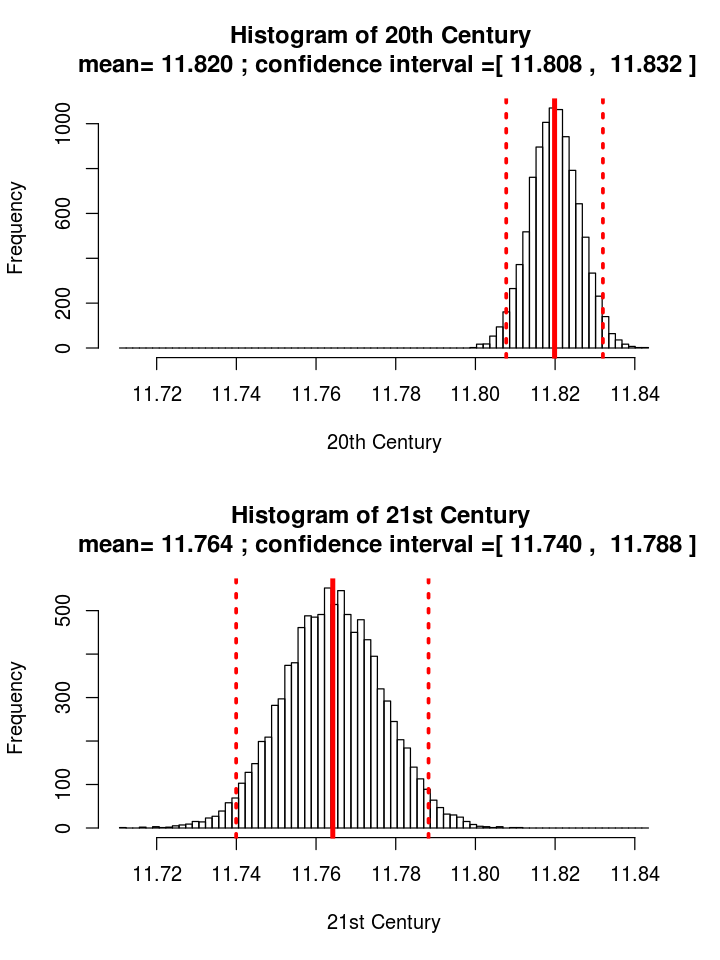

In [36]:
## Bootstrap the mean of the gas vs. diesel, plot individual histograms
mean.boot.20cent = one.boot(real_estate.20cent$log.price_sqm, mean, R = 10000)
mean.boot.21cent = one.boot(real_estate.21cent$log.price_sqm, mean, R = 10000)
options(repr.plot.width=6, repr.plot.height=8)
plot.t(mean.boot.20cent$t, mean.boot.21cent$t, nbins = 80, 
       cols = c('20th Century', '21st Century'), format_digits = 3)


# Plot the difference
options(repr.plot.width=6, repr.plot.height=3)
two.boot.mean = two.boot(real_estate.20cent$log.price_sqm, 
                         real_estate.21cent$log.price_sqm, mean, R = 10000)
plot.diff(two.boot.mean$t)

## Possible ways to split things (like autos/fuel/body...)
- Build year before/after 2000
- material
- state
- rooms
** Try out bootstrapped difference of means**

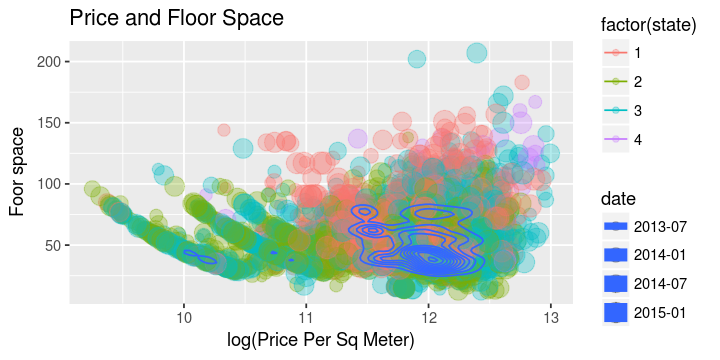

In [38]:
ggplot(real_estate, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

In [39]:
# For non-normlized, probalby non-sqled
x_min = 7.5
x_max = 13.0
y_min = 0
y_max = 2

Warning message:
“Removed 9222 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 9222 rows containing missing values (geom_point).”

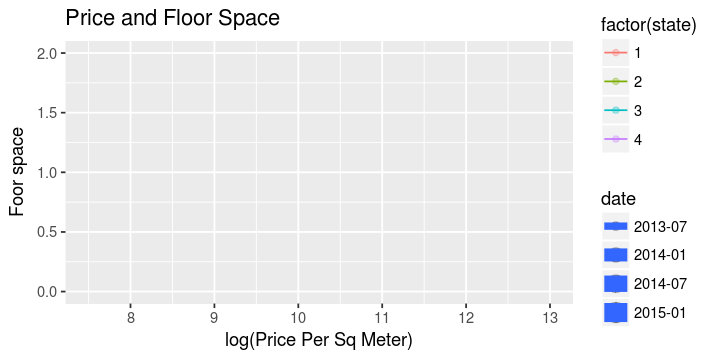

In [40]:
ggplot(real_estate, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
xlim(c(x_min, x_max)) + ylim(c(y_min, y_max)) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

In [41]:
head(real_estate)

timestamp             full_sq life_sq floor max_floor material build_year
5  5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6  5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7  5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
8  5/30/2013 12:00:00 AM 74      46      12    24        1        2004      
9  6/1/2013 12:00:00 AM  51      30       7    17        1        2003      
10 6/3/2013 12:00:00 AM  77      50       3     5        2        1957      
   num_room kitch_sq state ⋯ office_count_3000 office_sqm_3000 prom_part_5000
5  2        6        3     ⋯   1                 15000          8.05         
6  1        8        3     ⋯  15                136990         11.12         
7  2        1        1     ⋯   0                     0          6.54         
8  3        9        3     ⋯   8                115507         12.31         
9  2        9        3     ⋯   3                183000         13.57         
10 3        8        2     ⋯ 145               3353936         14.54         
   office_count_5000 office_sqm_5000 price_doc price_sqm date      
5    3                 81947          7100000  157777.78 2013-05-27
6   83               3903973          6450000  169736.84 2013-05-28
7    1                 26950          5903808   93711.24 2013-05-28
8   30                651686         12100000  163513.51 2013-05-30
9   11                385012          7700000  150980.39 2013-06-01
10 426               6956461         11700000  151948.05 2013-06-03
   log.price_sqm century
5  11.96894      20     
6  12.04200      20     
7  11.44797      21     
8  12.00465      21     
9  11.92491      21     
10 11.93129      20

In [42]:
head(real_estate$log.price_sqm)

[1] 11.96894 12.04200 11.44797 12.00465 11.92491 11.93129

From [stack overvlow](https://stackoverflow.com/questions/19483415/subset-a-dataframe-by-multiple-factor-levels)

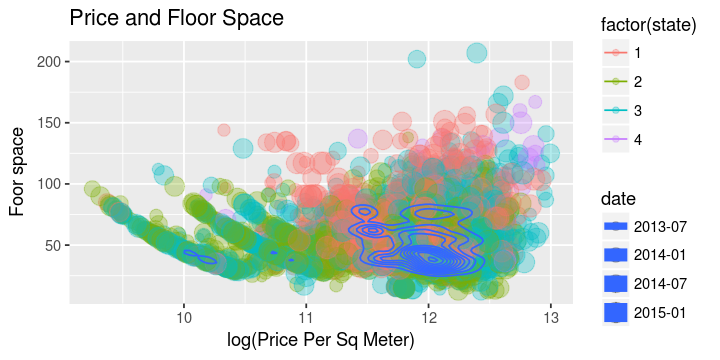

In [43]:
ggplot(real_estate, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

#### Set up some plotting functions.

In [44]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$logPrice)
  SST <- sum((df$logPrice - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

In [45]:
## Segment by Time & type (do some forecasting after all?)

# CHOICE OF MODELS
Explain your choice of models and discuss the model results using text, charts and tables. Models should be within the scope of the course. You may use any combination of R, Python and Azure Machine Learning for your analysis.

Have appropriate steps been taken to improve the model? For example, feature engineering, feature selection, dealing with case imbalances, dealing  with data problems?

## Use these

- **HW01** scatterplot matrices, density plot, density2d

- **HW02** faceted histograms, multiple density plots

- **HW05** Bootstrapping, difference of means (similar to HW4, but easier & better)

- **HW07** Regression initial way to find the vars

## Drop These

- **HW03** monty hall simulation (_skip?_)

## UNIDEN

- **HW04** normalizing, historgrams, t-test, ANOVA, Tukey HSD

- **HW06** Bayesian. very similar results to HW05, a bit harder to do.

- **HW08** Time Series, Dairy, Forecasting

Basic Goals
- Wrap our Heads around pricing behavior
- Figure out which features might be important
- Tease things apart a'la autos, fuel, apsiration, body

## Normalize the Numeric Fields

In [46]:
str(real_estate)

'data.frame':	9222 obs. of  68 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

In [78]:
fields.numeric = c(
    'build_year',
    'floor',
    'full_sq',
    'healthcare_centers_raion',
    'hospital_beds_raion',
    'kitch_sq',
    'life_sq',
    'material',
    'max_floor',
    'num_room',
    'office_count_1000',
    'office_count_1500',
    'office_count_2000',
    'office_count_3000',
    'office_count_500',
    'office_count_5000',
    'office_raion',
    'office_sqm_1000',
    'office_sqm_1500',
    'office_sqm_2000',
    'office_sqm_3000',
    'office_sqm_500',
    'office_sqm_5000',
    'price_doc',
    'state',
    'big_road1_km',
    'big_road2_km',
    'bulvar_ring_km',
    'bus_terminal_avto_km',
    'cemetery_km',
    'detention_facility_km',
    'hospice_morgue_km',
    'log.price_sqm',
    'metro_km_avto',
    'metro_km_walk',
    'metro_min_avto',
    'metro_min_walk',
    'mkad_km',
    'office_km',
    'oil_chemistry_km',
    'price_sqm',
    'prom_part_1000',
    'prom_part_1500',
    'prom_part_2000',
    'prom_part_3000',
    'prom_part_500',
    'prom_part_5000',
    'public_healthcare_km',  
    'public_transport_station_km',
    'public_transport_station_min_walk',
    'railroad_km',
    'railroad_station_avto_km',
    'railroad_station_avto_min',
    'railroad_station_walk_km',
    'railroad_station_walk_min',
    'sadovoe_km',
    'ttk_km',
    'zd_vokzaly_avto_km'
)

In [79]:
fields.date = c('date')

In [80]:
fields.other = c(
    'big_road1_1line',
    'detention_facility_raion',
    'oil_chemistry_raion',
    'product_type',
    'railroad_1line',
    'railroad_terminal_raion',
    'sub_area',
    'timestamp'
)

In [81]:
# For datasets that haven't been normalized
real_estate = na.omit(real_estate)
real_estate.scaled = real_estate
real_estate.scaled[, fields.numeric] = 
    lapply(real_estate[, fields.numeric],scale)
# real_estate.scaled = na.omit(real_estate.scaled)
head(real_estate.scaled, 3)
head(real_estate, 3)

timestamp             full_sq    life_sq     floor     max_floor  material  
5 5/27/2013 12:00:00 AM -0.3650744 -0.31669508 -0.203514 -0.6325538 -0.6241314
6 5/28/2013 12:00:00 AM -0.7394570 -0.82912576  1.631494  0.6015455 -0.6241314
7 5/28/2013 12:00:00 AM  0.5976238 -0.09708193  2.039274  0.7778454  1.3876617
  build_year  num_room    kitch_sq   state      ⋯ office_count_3000
5 -0.59285983  0.09834295 -0.1953868  0.9958228 ⋯ -0.4522800       
6  0.06768787 -1.13556005  0.4257290  0.9958228 ⋯ -0.3155261       
7  1.77410276  0.09834295 -1.7481764 -1.5701112 ⋯ -0.4620481       
  office_sqm_3000 prom_part_5000 office_count_5000 office_sqm_5000 price_doc 
5 -0.6553271      -0.7637417     -0.5853166        -0.7755615      -0.1386796
6 -0.5598786      -0.2294867     -0.1607054         0.6677685      -0.2748252
7 -0.6670635      -1.0265185     -0.5959319        -0.7963303      -0.3892278
  price_sqm  date       log.price_sqm century
5  0.1451710 2013-05-27  0.3019191    20     
6  0.3549915 2013-05-28  0.4384154    20     
7 -0.9788695 2013-05-28 -0.6713736    21

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_count_3000 office_sqm_3000 prom_part_5000
5 2        6        3     ⋯  1                 15000           8.05         
6 1        8        3     ⋯ 15                136990          11.12         
7 2        1        1     ⋯  0                     0           6.54         
  office_count_5000 office_sqm_5000 price_doc price_sqm date      
5  3                  81947         7100000   157777.78 2013-05-27
6 83                3903973         6450000   169736.84 2013-05-28
7  1                  26950         5903808    93711.24 2013-05-28
  log.price_sqm century
5 11.96894      20     
6 12.04200      20     
7 11.44797      21

In [83]:
keeps = c(
 'material',
 'healthcare_centers_raion',
 'state',
 'zd_vokzaly_avto_km',
 'office_km',
 'public_healthcare_km',
 'prom_part_1500',
 'kitch_sq',
 'hospital_beds_raion',
 'build_year',
 'metro_km_walk',
 'big_road1_km',
 'log.price_sqm'
)

real_estate.scaled = real_estate.scaled[,(names(real_estate.scaled) %in% keeps)]
dim(real_estate.scaled)
head(real_estate.scaled)

[1] 9222   13

material    build_year  kitch_sq   state      hospital_beds_raion
5  -0.62413143 -0.59285983 -0.1953868  0.9958228 -1.1242936         
6  -0.62413143  0.06768787  0.4257290  0.9958228 -0.4876708         
7   1.38766166  1.77410276 -1.7481764 -1.5701112 -0.6432897         
8  -0.62413143  1.27869199  0.7362870  0.9958228 -1.0771363         
9  -0.62413143  1.22364635  0.7362870  0.9958228 -0.4452293         
10  0.04646627 -1.30845317  0.4257290 -0.2871442 -0.1905802         
   healthcare_centers_raion metro_km_walk big_road1_km zd_vokzaly_avto_km
5   0.02950947              -0.710806356  -0.7752661    1.51078594       
6   0.68368342               2.033051311  -0.5541009   -0.31430464       
7  -1.27883842               1.575384925   0.1813480    2.02094103       
8  -1.27883842               0.093506622   0.5780651   -0.06093187       
9   0.02950947              -0.002391213   0.1028373    1.75493886       
10 -1.27883842              -0.697451352  -1.1174970   -1.65209939       
   public_healthcare_km office_km   prom_part_1500 log.price_sqm
5  -1.2099930            0.98568144 -1.0115455      0.3019191   
6   0.8665649            0.06583101  0.7291812      0.4384154   
7   2.3985261            2.80270500  1.8161215     -0.6713736   
8   0.3320625           -0.45018201  0.2911605      0.3686301   
9  -1.1536277            0.06013163  1.5070735      0.2196466   
10 -0.3311092           -0.67461071  0.4533904      0.2315822

## Stepwise Regression
**This is probably a bad idea** Too many features, per Stephen.  High risk of getting trapped at a local maximum.  Elastic Net would be a way-better idea.

From [stack overflow](https://stackoverflow.com/questions/4605206/drop-data-frame-columns-by-name)

In [84]:
# For datasets that haven't been normalized
drops = c("timestamp", "date", "max_floor")
real_estate.scaled = real_estate.scaled[,!(names(real_estate.scaled) %in% drops)]
head(real_estate.scaled, 3)
dim(real_estate.scaled)

material   build_year  kitch_sq   state      hospital_beds_raion
5 -0.6241314 -0.59285983 -0.1953868  0.9958228 -1.1242936         
6 -0.6241314  0.06768787  0.4257290  0.9958228 -0.4876708         
7  1.3876617  1.77410276 -1.7481764 -1.5701112 -0.6432897         
  healthcare_centers_raion metro_km_walk big_road1_km zd_vokzaly_avto_km
5  0.02950947              -0.7108064    -0.7752661    1.5107859        
6  0.68368342               2.0330513    -0.5541009   -0.3143046        
7 -1.27883842               1.5753849     0.1813480    2.0209410        
  public_healthcare_km office_km  prom_part_1500 log.price_sqm
5 -1.2099930           0.98568144 -1.0115455      0.3019191   
6  0.8665649           0.06583101  0.7291812      0.4384154   
7  2.3985261           2.80270500  1.8161215     -0.6713736

[1] 9222   13

In [85]:
lm.real_estate.scaled = lm(log.price_sqm ~ ., data = real_estate.scaled,)
summary(lm.real_estate.scaled)


Call:
lm(formula = log.price_sqm ~ ., data = real_estate.scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9189 -0.0541  0.2578  0.5055  1.8611 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -1.111e-15  1.010e-02   0.000 1.000000    
material                  1.321e-02  1.052e-02   1.256 0.208973    
build_year               -9.793e-04  1.179e-02  -0.083 0.933784    
kitch_sq                  3.741e-02  1.256e-02   2.978 0.002905 ** 
state                     8.871e-02  1.233e-02   7.194 6.78e-13 ***
hospital_beds_raion       1.670e-02  1.102e-02   1.515 0.129827    
healthcare_centers_raion -1.115e-02  1.293e-02  -0.862 0.388597    
metro_km_walk            -2.764e-02  1.205e-02  -2.293 0.021877 *  
big_road1_km             -4.948e-02  1.103e-02  -4.486 7.35e-06 ***
zd_vokzaly_avto_km       -1.792e-01  1.773e-02 -10.105  < 2e-16 ***
public_healthcare_km     -4.010e-02  1.482e-02  -2.706 0.006818 ** 
office_km

## Elastic Net

In [86]:
mod.mat = model.matrix(log.price_sqm ~ . -1, data = real_estate.scaled)
head(mod.mat)
dim(mod.mat)
range(mod.mat)

material    build_year  kitch_sq   state      hospital_beds_raion
5  -0.62413143 -0.59285983 -0.1953868  0.9958228 -1.1242936         
6  -0.62413143  0.06768787  0.4257290  0.9958228 -0.4876708         
7   1.38766166  1.77410276 -1.7481764 -1.5701112 -0.6432897         
8  -0.62413143  1.27869199  0.7362870  0.9958228 -1.0771363         
9  -0.62413143  1.22364635  0.7362870  0.9958228 -0.4452293         
10  0.04646627 -1.30845317  0.4257290 -0.2871442 -0.1905802         
   healthcare_centers_raion metro_km_walk big_road1_km zd_vokzaly_avto_km
5   0.02950947              -0.710806356  -0.7752661    1.51078594       
6   0.68368342               2.033051311  -0.5541009   -0.31430464       
7  -1.27883842               1.575384925   0.1813480    2.02094103       
8  -1.27883842               0.093506622   0.5780651   -0.06093187       
9   0.02950947              -0.002391213   0.1028373    1.75493886       
10 -1.27883842              -0.697451352  -1.1174970   -1.65209939       
   public_healthcare_km office_km   prom_part_1500
5  -1.2099930            0.98568144 -1.0115455    
6   0.8665649            0.06583101  0.7291812    
7   2.3985261            2.80270500  1.8161215    
8   0.3320625           -0.45018201  0.2911605    
9  -1.1536277            0.06013163  1.5070735    
10 -0.3311092           -0.67461071  0.4533904

[1] 9222   12

[1] -1.916103  6.178337

Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13

Loading required package: gridExtra
`geom_smooth()` using method = 'gam'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


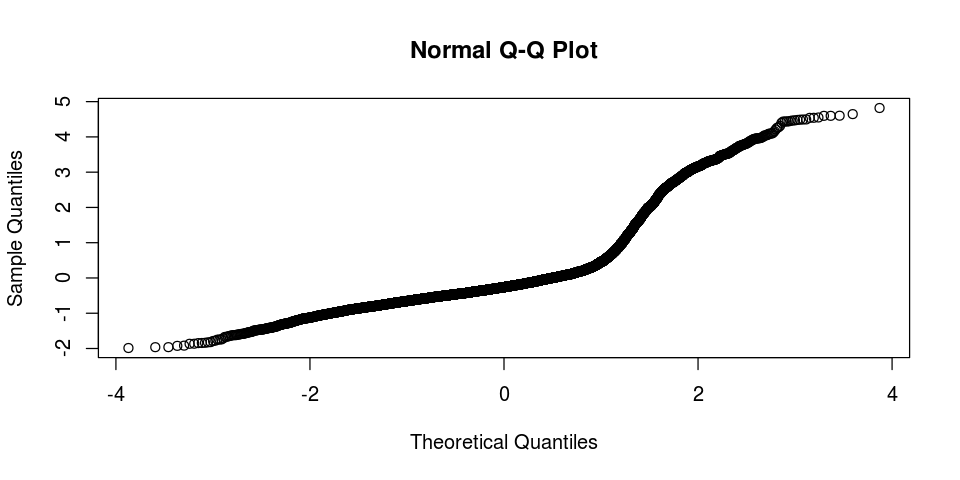

`geom_smooth()` using method = 'gam'
Warning message in mean.default(df$logPrice):
“argument is not numeric or logical: returning NA”

SSE = -8782.09136376418 
SSR = 8782.09136376418 
SST = 0 
RMSE = -0.952504486308479 
Adjusted R^2 = -Inf 


In [87]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.5)
real_estate.enet = real_estate.scaled
real_estate.enet$score = predict(mod.lasso, newx = mod.mat)[, 15]
real_estate.enet$resids = real_estate.enet$score - real_estate.enet$log.price_sqm
plot.svd.reg(real_estate.enet)

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso.a0 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.0)
real_estate.enet.a0 = real_estate.scaled
real_estate.enet.a0$score = predict(mod.lasso.a0, newx = mod.mat)[, 15]
real_estate.enet.a0$resids = real_estate.enet.a0$score - 
                            real_estate.enet.a0$log.price_sqm
plot.svd.reg(real_estate.enet.a0)

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso.a1 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 1.0)
real_estate.enet.a1 = real_estate.scaled
real_estate.enet.a1$score = predict(mod.lasso.a1, newx = mod.mat)[, 15]
real_estate.enet.a1$resids = real_estate.enet.a1$score - 
                            real_estate.enet.a1$log.price_sqm
plot.svd.reg(real_estate.enet.a1)

In [ ]:
alpha.sweep <- function(step=0.1){
  for (alpha in seq(0.0, 1.0, by=step)){
      print(paste("alpha is", alpha, "--------------------------------------"))
      b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
      mod.lasso.a1 = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 1.0)
      real_estate.enet.a1 = real_estate.scaled
      real_estate.enet.a1$score = predict(mod.lasso.a1, newx = mod.mat)[, 15]
      real_estate.enet.a1$resids = real_estate.enet.a1$score - 
                                    real_estate.enet.a1$log.price_sqm
      plot.svd.reg(real_estate.enet.a1)
    }
}

In [ ]:
# alpha.sweep(step=0.001)

## Try some SVD

In [ ]:
svdM = svd(mod.mat)
d = svdM$d
plot(log(d))

In [ ]:
d.trimmed = d[1:(length(d)-90)]
plot(log(d.trimmed))

In [ ]:
# end.trim = length(d) - 90
end.trim = length(d) - 200
d.trimmed.2 = d[1:end.trim]
plot(log(d.trimmed.2))

In [ ]:
D = diag(1/svdM$d)

last = length(d)
D[end.trim:last,end.trim:last] = 0.0

head(D)
tail(D, last - end.trim + 90)

### Compute the pseudo-inverse Matrix

In [ ]:
mInv = svdM$v %*% D %*% t(svdM$u)
head(mInv, 3)

In [ ]:
bM = mInv %*% real_estate$log.price_sqm
bM

In [ ]:
real_estate.svd = real_estate

real_estate.svd$score = mod.mat %*% bM + mean(real_estate.svd$log.price_sqm)
real_estate.svd$resids = real_estate.svd$score - real_estate.svd$log.price_sqm

In [ ]:
plot.svd.reg(real_estate.svd)

# ANALYSIS
Is the analysis method selected appropriate to the question being addressed?


# CONCLUSION
Are there a clear conclusion supported by the evidence and inferences drawn from the exploratory analysis and an appropriate statistical model presented, even if the result is negative? Are the results understandable to a non-technical audience?

Are the conclusions and inferences drawn from the model clear, concise and directed at the stated problem?
    